# UK Domestic Load Forecasting
Time series modeling for smarter grid operations

This project builds a day-ahead forecast of UK electricity demand using 2023 historical data. The model predicts 48 half-hourly settlement periods for the next day from the current day's load profile. Accurate short-term forecasts enable better balancing of supply and demand, smarter storage dispatch, and more efficient network operations.

What's inside:
- Data preparation and integrity checks
- Feature/label construction for day-ahead forecasting
- Baseline linear regression
- Tree-based model with hyperparameter tuning
- Evaluation on a held-out dataset and clear metrics

Outcome: a reproducible workflow and interpretable metrics suitable for operational decision support.

## Reproducibility and usage

- Python ecosystem: pandas, numpy, scikit-learn, matplotlib, seaborn.
- Data files: `UKLoad2023.json` (train) and `UKLoad2023_test.json` (evaluation) are included in the repo.
- Run the notebook top-to-bottom to reproduce results. For deterministic splits, set a fixed `random_state` where provided.
- The notebook keeps code readable, with small, composable steps and visual checks.

## Data Overview
The source dataset (`UKLoad2023.json`) contains half-hourly UK system demand measurements for 2023. Each record includes:
- `settlementDate`: calendar date
- `settlementPeriod`: index (1–48) for each 30‑minute interval
- `quantity`: demand in MW
Supporting metadata fields (IDs, publish times) are retained for traceability but not used as predictive features.

Forecasting objective: given a full day's 48-period profile, predict the next day's 48-period demand values. This framing converts raw time series into paired (feature day, label day) samples enabling supervised learning.

Business relevance: improved day-ahead accuracy supports:
1. Economic dispatch of storage and flexible demand
2. Better integration of intermittent renewables
3. Reduction of imbalance penalties
4. Lower carbon intensity through optimized scheduling

## Data preparation
We prepare the dataset for day-ahead supervised learning by:
- Removing duplicate records
- Handling missing values with simple, defensible imputation
- Building daily feature/label matrices (48 half-hourly values per row) where labels are the next day's values
- Visualizing a representative example and validating basic statistics

These steps ensure clean inputs and aligned targets prior to model training and evaluation.

### Notes on integrity, imputation, and dataset shape

- Duplicates: removed when present to avoid data leakage or bias.
- Missing values: imputed with the column mean for numeric fields to preserve trends without distorting scale.

Supervised matrices:
- `feature_dataset`: N × 48 matrix of daily profiles (inputs).
- `label_dataset`: N × 48 matrix of subsequent day profiles (targets), aligned by date.

Visualization and statistics:
- Plot a representative day from both matrices to illustrate the task.
- Report shapes, basic moments, and NaN counts to validate readiness.

In [ ]:
# Imports and notebook setup

import pandas as pd # pandas module required for dataset manipulation
import numpy as np # numpy module required for numerical calculation, signal processing and training.
from sklearn.linear_model import LinearRegression # the model LinearRegression from sklearn.linear_model is required for Part 2 
from sklearn.model_selection import train_test_split # the function train_test_split is required from sklearn.model_selection for training and testing dataset preparation.

###################################################
import matplotlib.pyplot as plt  #for visualization
import seaborn as sns  #for visualizing heatmaps (part 1.6)
import torch
import torch.nn.functional as F
import math
##Part 2##
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
##Part 3##
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler



###################################################
# General configuration and helper imports for the notebook.




In [ ]:
# Utility metrics used for evaluation
def performance_indicator_relative(mse_train, mse_test, mse_validation):
    return abs(mse_validation - mse_train) / abs(mse_train) + abs(mse_validation - mse_test) / abs(mse_test)

def performance_indicator_rmse(mse_validation, Y_labels):
    return mse_validation/(np.mean(Y_labels)**2)

Number of duplicate rows: 1
Data shape after removing duplicates: (4467, 8)
Missing values before imputation:
dataset                   0
documentId                0
documentRevisionNumber    0
publishTime               0
startTime                 0
settlementDate            0
settlementPeriod          0
quantity                  3
dtype: int64
Missing values after imputation:
dataset                   0
documentId                0
documentRevisionNumber    0
publishTime               0
startTime                 0
settlementDate            0
settlementPeriod          0
quantity                  0
dtype: int64


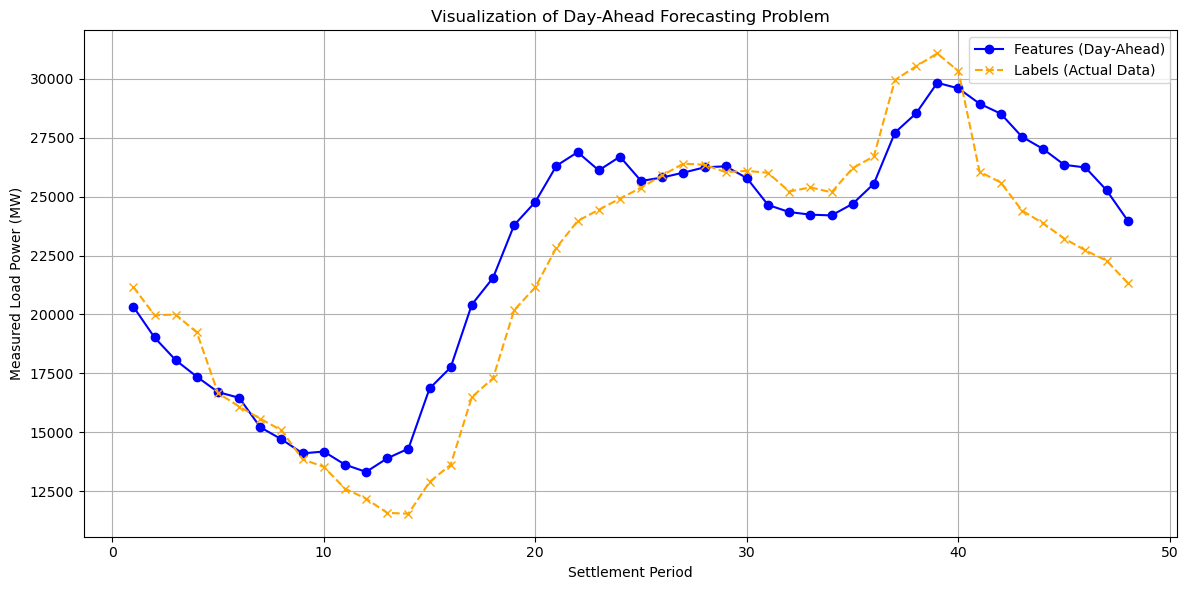

Mean of Feature Dataset:  [23484.62365591 22515.95698925 21170.76344086 20696.10418428
 19926.60215054 19703.49462366 19237.92473118 18857.30107527
 18504.34408602 18343.72043011 17959.53763441 17930.59139785
 18149.2688172  18838.4516129  20983.84946237 22464.79569892
 25603.56989247 26947.62365591 30055.82795699 30980.66666667
 32438.70967742 32945.21505376 33103.62365591 33357.33333333
 33546.60215054 33743.22246385 33896.88172043 34200.20430108
 33795.79569892 33493.94623656 32907.35483871 32608.19354839
 32054.58064516 32048.49462366 32109.90322581 32486.84946237
 32656.69892473 32653.28697998 32101.07526882 31932.84946237
 31736.49462366 31254.04301075 30554.4516129  29888.21505376
 28767.20430108 27780.10752688 25931.56989247 24657.74193548]
Mean of Label Dataset:  [23530.6344086  22563.         21194.06451613 20719.11493696
 19947.58064516 19723.27956989 19268.60215054 18891.62365591
 18547.70967742 18384.34408602 17995.80645161 17970.06451613
 18184.37634409 18870.39784946 210

In [ ]:
# Data loading and preparation

# Load the training dataset
df = pd.read_json('UKLoad2023.json')

# Duplicate check and remediation

#check for duplicate rows based on all columns
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

#if found, drop any duplicates
df_cleaned = df.drop_duplicates()
print(f"Data shape after removing duplicates: {df_cleaned.shape}")

# Missing value handling (numeric mean imputation)

#display missing values before imputation
print("Missing values before imputation:")
print(df.isna().sum())

#select numeric columns only for imputation
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

#impute missing values in numeric columns by filling with the column mean (chosen implementation)
for col in numeric_cols:
    mean_value = df[col].mean()
    df[col] = df[col].fillna(mean_value)

#display missing values after imputation
print("Missing values after imputation:")
print(df.isna().sum())


# Prepare day-ahead feature/label matrices
# check datafram length to only process complete days
num_samples = len(df) // 48 * 48  # only considering multiples of 48

#initialization of feature and label dataset
feature_dataset = np.zeros((num_samples // 48, 48))  # Each day has 48 values
label_dataset = np.zeros((num_samples // 48, 48))  # Next day's data

#fill the feature_dataset with 48 values per day
for i in range(0, num_samples - 48, 48):  # loop over data with a ++step of 48
    feature_dataset[i // 48] = df['quantity'].iloc[i:i+48].values
    label_dataset[i // 48] = df['quantity'].iloc[i+48:i+96].values


# Visualize one representative day
# selecting the first row for visualization as per requirements
day_features = feature_dataset[0, :]  # 1st row of feature_dataset
day_labels = label_dataset[0, :]  #1st row of label_dataset

#settlement periods for x-axis
settlement_periods = np.arange(1, day_features.shape[0] + 1)

#creating plot and showing the data
plt.figure(figsize=(12, 6))
plt.plot(settlement_periods, day_features, label="Features (Day-Ahead)", marker='o', color='blue')
plt.plot(settlement_periods, day_labels, label="Labels (Actual Data)", marker='x', linestyle='--', color='orange')
#plot enhancement
plt.title("Visualization of Day-Ahead Forecasting Problem")
plt.xlabel("Settlement Period")
plt.ylabel("Measured Load Power (MW)")
plt.legend()
plt.grid(True)
#plot display
plt.tight_layout()
plt.show()


# Basic dataset statistics
#mean values for feature and label dataset
feature_mean = np.mean(feature_dataset, axis=0)
label_mean = np.mean(label_dataset, axis=0)

#print the mean values of the feature and label datasets
print("Mean of Feature Dataset: ", feature_mean)
print("Mean of Label Dataset: ", label_mean)

#show the shape of the feature and label datasets
print("\nFeature Dataset Shape: ", feature_dataset.shape)
print("Label Dataset Shape: ", label_dataset.shape)

#number of samples (days)
num_samples = feature_dataset.shape[0]
print("\nNumber of samples (days): ", num_samples)

#check for any further missing values in feature and label datasets
print("\nMissing values in feature dataset: ", np.isnan(feature_dataset).sum())
print("Missing values in label dataset: ", np.isnan(label_dataset).sum())

##




## Baseline model: Linear regression

We train a multivariate linear regression that maps a day's 48 half-hourly values to the next day's 48 values.

Evaluation includes:
- Train/test split
- MSE on both splits
- Visualization of predicted vs. true profiles for a representative sample

### Baseline analysis and suggestions

- Expectation: training MSE is typically lower than test MSE due to the generalization gap.
- If the gap is large, consider regularization, improved validation splits, or richer features.
- For reproducibility, set a fixed random seed for data splits and model initialization.

---------------------------------------------------------------------------
MSE Performance for Part 2:
Linear Regression MSE Train: 5.3000050157346813e-20
Linear Regression MSE Test: 531419597.32084566
---------------------------------------------------------------------------


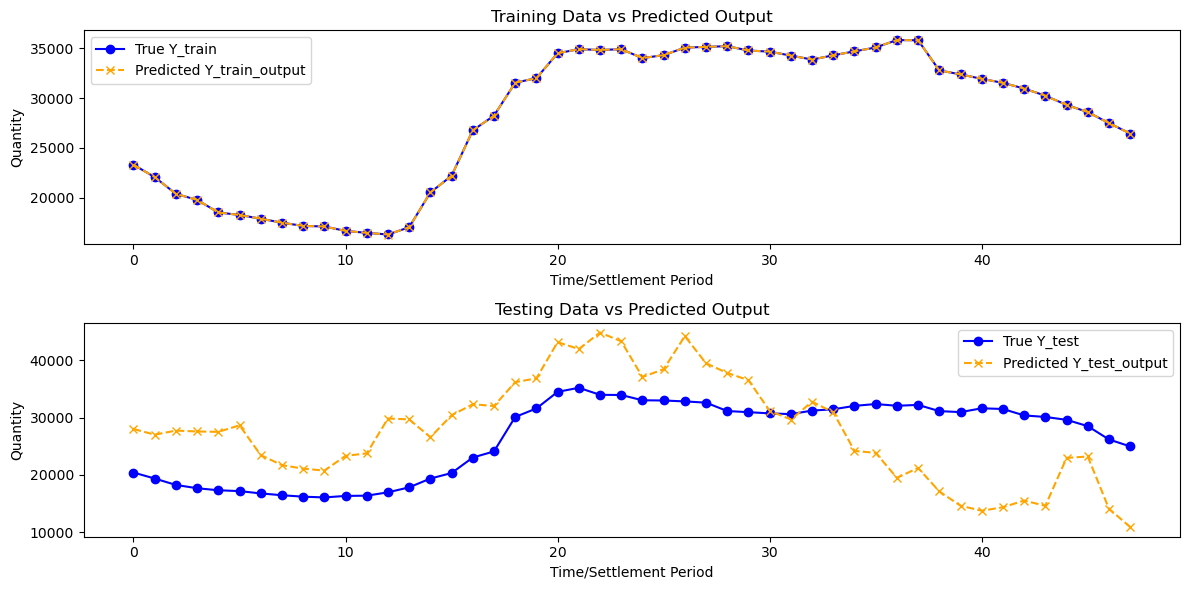

In [ ]:
# Example: dataset split, model training (Linear Regression), and evaluation.
# This ensures variables from Part 1 are correctly shaped and named.

# Training and Testing dataset preparation. Splitting ratio between training and testing is set as 50% vs 50% as an example.
X_train, X_test, Y_train, Y_test = train_test_split(feature_dataset, label_dataset, test_size=0.5)

# Configuring the models to fit/train. 
cwk_model_part2 = LinearRegression()

# Fitting the models with the training data.
cwk_model_part2.fit(X_train, Y_train)

# Making predictions with the fitted model
Y_train_output = cwk_model_part2.predict(X_train)

# Making predictions with the fitted model
Y_test_output= cwk_model_part2.predict(X_test)

###################################################
# Compute MSE metrics
###################################################
# Write code to calculate the Mean Squared Error (MSE) performance for both the training part and the testing part, with the name of mse_train and mse_test, correspondingly. You will need to follow this naming convention for Part 3.

#value initialization - you might need to rewrite/remove this part if necessary
mse_train = mean_squared_error(Y_train, Y_train_output)
mse_test = mean_squared_error(Y_test, Y_test_output)
#


###################################################
# Metrics summary
print("---------------------------------------------------------------------------")
print("MSE Performance for Part 2:")
print(f"Linear Regression MSE Train: {mse_train}")
print(f"Linear Regression MSE Test: {mse_test}")
print("---------------------------------------------------------------------------")

###################################################
# Visualize model fit for a representative sample
###################################################
# Write code to visualize the model fitting performance. You should plot the first row of Y_train and Y_train_output, first row of Y_test_output and Y_test.
# Visualizing the first row of Y_train and Y_train_output, Y_test_output and Y_test

plt.figure(figsize=(12, 6))

# plot the training data vs predicted output for 1st sample
plt.subplot(2, 1, 1)
plt.plot(Y_train[0], label="True Y_train", marker='o', color='blue')
plt.plot(Y_train_output[0], label="Predicted Y_train_output", marker='x', linestyle='--', color='orange')
plt.title("Training Data vs Predicted Output")
plt.xlabel("Time/Settlement Period")
plt.ylabel("Quantity")
plt.legend()

# plot testing data vs predicted output for 1st sample
plt.subplot(2, 1, 2)
plt.plot(Y_test[0], label="True Y_test", marker='o', color='blue')
plt.plot(Y_test_output[0], label="Predicted Y_test_output", marker='x', linestyle='--', color='orange')
plt.title("Testing Data vs Predicted Output")
plt.xlabel("Time/Settlement Period")
plt.ylabel("Quantity")
plt.legend()

#display plot
plt.tight_layout()
plt.show()

#



## Model exploration: tree-based regressor

We evaluate a Random Forest Regressor with cross-validated hyperparameter tuning. This model captures nonlinearities and interactions without extensive feature engineering.

Process:
- Prepare input features and targets
- Apply consistent preprocessing
- Tune key hyperparameters via `GridSearchCV`
- Report training and testing MSE and discuss fit vs. generalization

### Model comparison and overfitting control

Rationale for tree ensemble: robustness to outliers, automatic interaction discovery, and reduced variance through aggregation.

Overfitting mitigation steps:
- Depth limitation
- Feature subsampling
- Cross-validation for hyperparameter selection

Comparison considers:
- Absolute MSE values
- Train vs. test gap
- Stability across CV folds

In [ ]:
# Random Forest regression with hyperparameter tuning

X = df.drop(['quantity', 'dataset', 'documentId', 'documentRevisionNumber', 'publishTime', 'startTime', 'settlementDate'], axis=1)
Y = df['quantity']

df_cleaned = df.drop(['dataset', 'documentId', 'documentRevisionNumber', 'publishTime', 'startTime', 'settlementDate'], axis=1)

imputer = SimpleImputer(strategy='mean')
df_cleaned.iloc[:, :] = imputer.fit_transform(df_cleaned)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train_scaled, Y_train)
best_rf = grid_search.best_estimator_

Y_train_pred = best_rf.predict(X_train_scaled)
Y_test_pred = best_rf.predict(X_test_scaled)

train_mse = mean_squared_error(Y_train, Y_train_pred)
test_mse = mean_squared_error(Y_test, Y_test_pred)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters from GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training MSE: 8110162.086444214
Testing MSE: 7324272.860279384


## Evaluation on held-out data

We load `UKLoad2023_test.json`, apply the same preprocessing pipeline, generate predictions, and compute MSE. We also report two normalized indicators for comparability across scales and visualize a short horizon for qualitative assessment.

### Next steps

- Add calendar features (day-of-week, holidays, seasonal markers) and, where available, weather covariates.
- Explore specialized time-series models (e.g., ARIMA/SARIMA, Prophet) and sequence models (e.g., LSTM, temporal CNNs).
- Use rolling-origin evaluation to better mirror operational deployment.
- Calibrate prediction intervals to quantify uncertainty for dispatch and risk-aware decisions.

Test MSE on evaluation dataset: 7932720.567319004


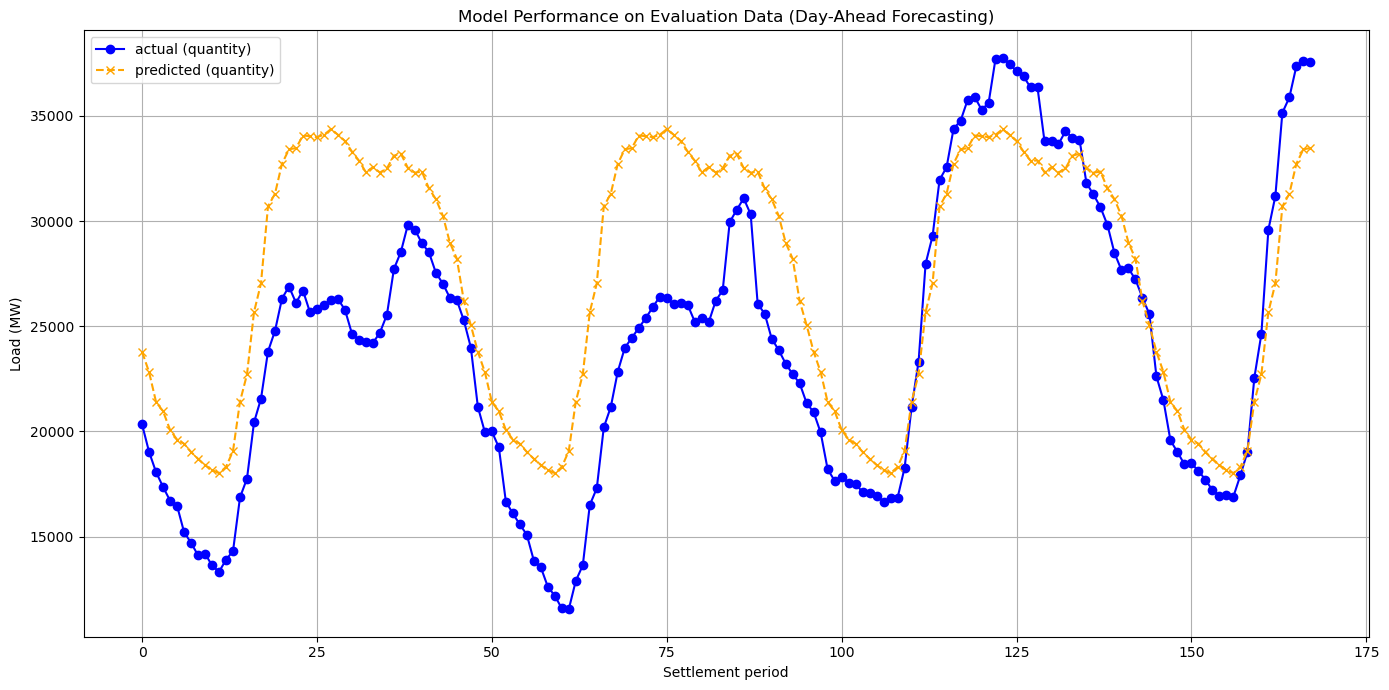

In [ ]:
# To load the evaluation dataset
df_evaluation = pd.read_json('UKLoad2023_test.json')


# Evaluate on held-out dataset

#handle any missing values in the evaluation dataset
df_evaluation = df_evaluation.dropna()  #drop rows with any NaN values

#prepare features and labels for dummy dataset (retain required feature and label)
feature_dataset_validation = df_evaluation.drop(['quantity', 'dataset', 'documentId', 'documentRevisionNumber', 'publishTime', 'startTime', 'settlementDate'], axis=1)
label_dataset_validation = df_evaluation['quantity']

#apply same scaling methods used in part 3
X_eval_scaled = scaler.transform(feature_dataset_validation)

#predict on the evaluation dataset using pt3 model
Y_eval_pred = best_rf.predict(X_eval_scaled)

# calculate mse for dummy dataset
mse_validation = mean_squared_error(label_dataset_validation, Y_eval_pred)

#print dummy dataset MSE
print(f"Test MSE on evaluation dataset: {mse_validation}")

# Plot a short horizon for qualitative assessment
# plot the actual vs predicted values for the evaluation dataset for a week (168 periods instead of 48)
plt.figure(figsize=(14, 7))
plt.plot(label_dataset_validation.values[:168], label="actual (quantity)", marker='o', color='blue')
plt.plot(Y_eval_pred[:168], label="predicted (quantity)", marker='x', linestyle='--', color='orange')
plt.title("Model Performance on Evaluation Data (Day-Ahead Forecasting)")
plt.xlabel("Settlement period")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Performance evaluation utilities
overall_performance = performance_indicator_relative(mse_train, mse_test, mse_validation)
print('overall_performance', overall_performance)

rmse_performance = performance_indicator_rmse(mse_validation, label_dataset_validation)
print('rmse_performance', rmse_performance)

overall_performance 1.496738313222026e+26
rmse_performance 0.01024027968530992
